In [1]:
from argopy import DataFetcher as ArgoDataFetcher
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
import xarray as xr
from scipy.optimize import curve_fit
import proplot as pplt
from os.path import exists

In [2]:
BOX = [-25, -15, 58, 62]

## Density

In [13]:
argo = ArgoDataFetcher(src='erddap', ds='bgc', mode='expert', parallel=True).float(5906217)
argo.data

ValueError: Errors happened with all URLs, this could be due to an internal impossibility to read returned content.

In [12]:
bgc = ArgoDataFetcher(src='erddap', ds='bgc', mode='expert').region([-38, -15, 50, 62, 0, 1000, '2000-01', '2022-05'])
bgc.data

FileNotFoundError: https://www.ifremer.fr/erddap/tabledap/ArgoFloats-synthetic-BGC.nc?parameter_data_mode,latitude,longitude,position_qc,time,time_qc,direction,platform_number,cycle_number,config_mission_number,pres,temp,psal,cndc,doxy,beta_backscattering,fluorescence_chla,bbp,turbidity,cp,chla,cdom,nitrate,pres_qc,temp_qc,psal_qc,cndc_qc,doxy_qc,beta_backscattering_qc,fluorescence_chla_qc,bbp_qc,turbidity_qc,cp_qc,chla_qc,cdom_qc,nitrate_qc,pres_adjusted,temp_adjusted,psal_adjusted,cndc_adjusted,doxy_adjusted,beta_backscattering_adjusted,fluorescence_chla_adjusted,bbp_adjusted,turbidity_adjusted,cp_adjusted,chla_adjusted,cdom_adjusted,nitrate_adjusted,pres_adjusted_qc,temp_adjusted_qc,psal_adjusted_qc,cndc_adjusted_qc,doxy_adjusted_qc,beta_backscattering_adjusted_qc,fluorescence_chla_adjusted_qc,bbp_adjusted_qc,turbidity_adjusted_qc,cp_adjusted_qc,chla_adjusted_qc,cdom_adjusted_qc,nitrate_adjusted_qc,pres_adjusted_error,temp_adjusted_error,psal_adjusted_error,cndc_adjusted_error,doxy_adjusted_error,beta_backscattering_adjusted_error,fluorescence_chla_adjusted_error,bbp_adjusted_error,turbidity_adjusted_error,cp_adjusted_error,chla_adjusted_error,cdom_adjusted_error,nitrate_adjusted_error&longitude>=-38&longitude<=-15&latitude>=50&latitude<=62&pres>=0&pres<=1000&time>=946684800.0&time<=1651363200.0&distinct()&orderBy("time,pres")

FileNotFoundError: https://www.ifremer.fr/erddap/tabledap/ArgoFloats-synthetic-BGC.nc?parameter_data_mode,latitude,longitude,position_qc,time,time_qc,direction,platform_number,cycle_number,config_mission_number,pres,temp,psal,cndc,doxy,beta_backscattering,fluorescence_chla,bbp,turbidity,cp,chla,cdom,nitrate,pres_qc,temp_qc,psal_qc,cndc_qc,doxy_qc,beta_backscattering_qc,fluorescence_chla_qc,bbp_qc,turbidity_qc,cp_qc,chla_qc,cdom_qc,nitrate_qc,pres_adjusted,temp_adjusted,psal_adjusted,cndc_adjusted,doxy_adjusted,beta_backscattering_adjusted,fluorescence_chla_adjusted,bbp_adjusted,turbidity_adjusted,cp_adjusted,chla_adjusted,cdom_adjusted,nitrate_adjusted,pres_adjusted_qc,temp_adjusted_qc,psal_adjusted_qc,cndc_adjusted_qc,doxy_adjusted_qc,beta_backscattering_adjusted_qc,fluorescence_chla_adjusted_qc,bbp_adjusted_qc,turbidity_adjusted_qc,cp_adjusted_qc,chla_adjusted_qc,cdom_adjusted_qc,nitrate_adjusted_qc,pres_adjusted_error,temp_adjusted_error,psal_adjusted_error,cndc_adjusted_error,doxy_adjusted_error,beta_backscattering_adjusted_error,fluorescence_chla_adjusted_error,bbp_adjusted_error,turbidity_adjusted_error,cp_adjusted_error,chla_adjusted_error,cdom_adjusted_error,nitrate_adjusted_error&longitude>=-38&longitude<=-15&latitude>=50&latitude<=62&pres>=0&pres<=1000&time>=946684800.0&time<=1651363200.0&distinct()&orderBy("time,pres")

In [11]:
bgc = bgc.argo.point2profile().argo.interp_std_levels(np.arange(0,1000))

/autofs/nas1/home/isimoesdesousa/programs/mambaforge/envs/pangeo-notebook/lib/python3.9/site-packages/argopy/xarray.py:1077: UserWarning: None of the profiles can be interpolated (not reaching the requested depth range).
  warnings.warn(


In [14]:
bgc.groupby("TIME.month")

AttributeError: 'NoneType' object has no attribute 'groupby'

In [12]:
bgcm = bgc.groupby("TIME.month").mean("N_PROF").sel(month=2) #FEB

KeyError: 2

In [30]:
if not(exists("data/argo_north_atlantic.nc")):
    argo = ArgoDataFetcher().region([*BOX, 0, 1000, '2010-01', '2020-12']).to_xarray()
    argo = argo.argo.point2profile().argo.interp_std_levels(np.arange(0,1000))

    argom = argo.groupby("TIME.month").mean("N_PROF").sel(month=2) #FEB
    argom = argom.assign(PDEN=("PRES_INTERPOLATED",sw.pden(argom.PSAL,argom.TEMP,argom.PRES_INTERPOLATED)))
    argom = argom.assign(B=-(9.82/1025)*argom.PDEN)
    argom = argom.rolling(PRES_INTERPOLATED=50,min_periods=1).mean()

    argom.to_netcdf("data/argo_north_atlantic.nc")
else:
    argom = xr.open_dataset("data/argo_north_atlantic.nc")

In [48]:
def func(z, a, b, c,d,e):
    return a * np.tanh(b*(z-c)) + d*z**2 + e

popt_argo, pcov_argo = curve_fit(func, argom.PRES_INTERPOLATED.values, argom.PDEN.values,p0=[0.2,6e-3,500,0,1027.6])
argom = argom.assign(PDENf=("PRES_INTERPOLATED",func(argom.PRES_INTERPOLATED.values,*popt_argo)))
argom = argom.assign(Bf=-(9.82/1025)*argom.PDENf)
title_argo = f"{popt_argo[0]:.2f} tanh( {popt_argo[1]:.04f}( z-{popt_argo[2]:.01f} ) ) {popt_argo[3]*1e5:.1f} 10$^5$ z + {popt_argo[4]:.2f}"

In [49]:
 f"{popt_argo[0]:.4f} tanh( {popt_argo[1]:.06f}( z-{popt_argo[2]:.03f} ) ) {popt_argo[3]*1e5:.3f} 10$^5$ z + {popt_argo[4]:.3f}"

'0.0887 tanh( 0.004867( z-618.138 ) ) 0.014 10$^5$ z + 1027.455'

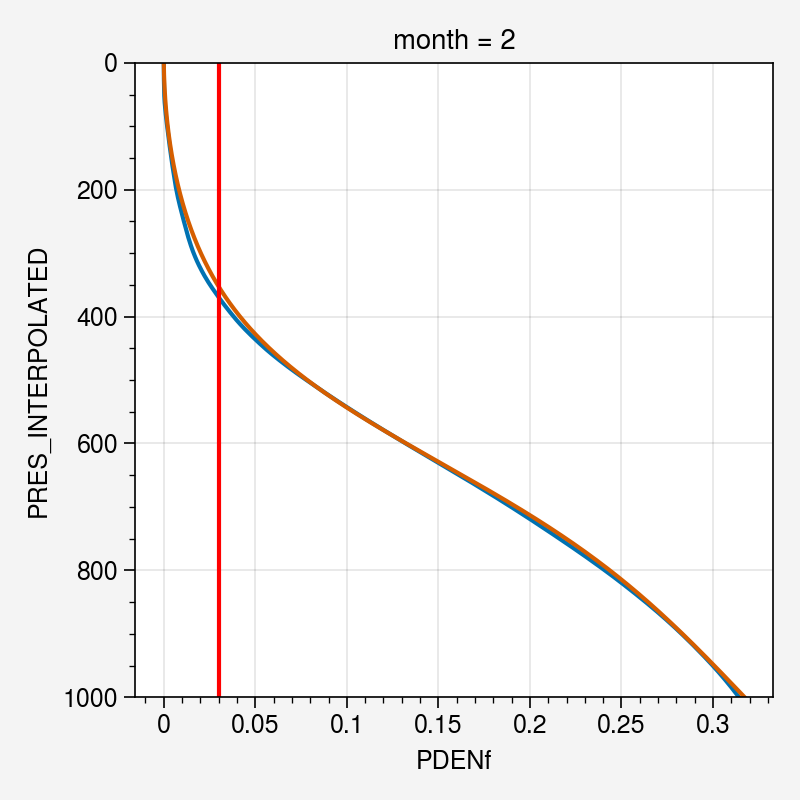

In [50]:
fig,ax = plt.subplots()
(argom.PDEN-argom.PDEN.sel(PRES_INTERPOLATED=0)).plot.line(y="PRES_INTERPOLATED")
(argom.PDENf-argom.PDENf.sel(PRES_INTERPOLATED=0)).plot.line(y="PRES_INTERPOLATED")
ax.set(ylim=[1000,0])
ax.axvline(0.03, color="red")
fig.tight_layout()

## Shortwave

In [38]:
# https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html
shortwave = xr.open_dataset("data/dswrf_sfc_mon_mean.nc")
shortwave = shortwave.assign(lon=(((shortwave.lon + 180) % 360) - 180)).sortby("lon")

shortwave_month = shortwave.sel(lon=np.mean(BOX[:2]), lat=np.mean(BOX[2:]), method="nearest").dswrf.groupby("time.month").mean()
shortwave_yearday = shortwave_month.assign_coords(month=np.linspace(0,365,12)).rename(month="yearday")

In [42]:
def func_shortwave(t, a, b, c, d):
    return a * np.sin(2*np.pi*t/b - c) + d

popt_shortwave, pcov_shortwave = curve_fit(func_shortwave, shortwave_yearday.yearday.values, shortwave_yearday.values, p0=[200, 365, 0, 100])
a, b, c, d = np.round(popt_shortwave,decimals=1)

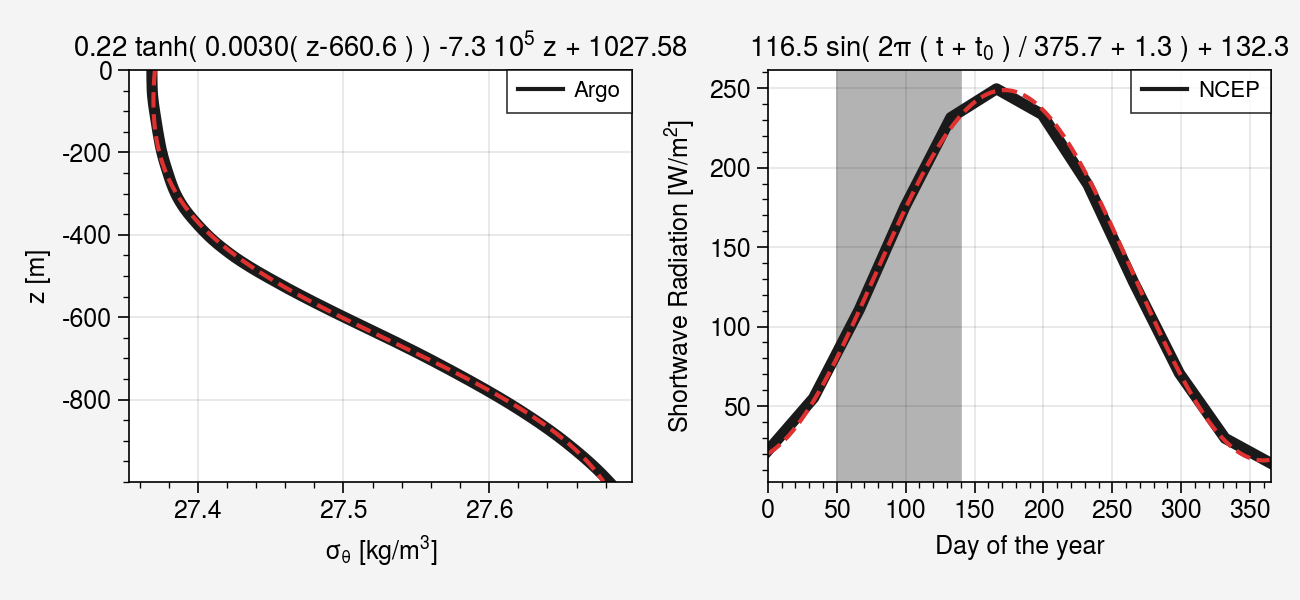

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(6.5,3))

_ = (argom.PDEN-1000).plot.line(ax=ax[0], y="PRES_INTERPOLATED", ylim=[1000,0], lw=4, color="0.1")
_ = (argom.PDENf-1000).plot.line(ax=ax[0], y="PRES_INTERPOLATED", ylim=[1000,0], linestyle="--", color="red8")
ax[0].set(
    xlabel="$\sigma_\\theta$ [kg/m$^{3}$]",
    ylabel="z [m]",
    yticks=np.arange(0, 1000, 200),
    yticklabels=-np.arange(0, 1000, 200),
    title=title_argo
)
ax[0].plot([], [], color="0.1", label="Argo")
ax[0].legend(loc=1, fontsize=8)

t0 = 50
shortwave_yearday.plot(ax=ax[1], lw=4, color="0.1")
ax[1].plot(np.arange(365), func_shortwave(np.arange(365), a, b, c, d), linestyle="--", color="red8")

ax[1].axvspan(t0, t0+90, color="0.7")
ax[1].set(
    ylabel="Shortwave Radiation [W/m$^{2}$]",
    xlabel="Day of the year",
    xlim=[0,365],
    xticks=np.arange(0,365,50),
    title=f"{a} sin( 2$\pi$ ( t + t$_0$ ) / {b} + {c} ) + {d}"
)
ax[1].plot([], [], color="0.1", label="NCEP")
ax[1].legend(loc=1, fontsize=8)
fig.tight_layout()